# Evaluation


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Settings
ndb_eager_filepath = '/home/christopher/Workspace/statefun-ndb-benchmark/output-data/24-05-2022_14:57/rocksdb-eager-3-workers-embedded-16000.json'
ndb_lazy_filepath = '/home/christopher/Workspace/statefun-ndb-benchmark/output-data/23-05-2022_12:49/rocksdb-lazy-3-workers-embedded-8000.json'
rocksdb_filepath = '/home/christopher/Workspace/statefun-ndb-benchmark/output-data/24-05-2022_16:18/rocksdb-eager-3-workers-embedded-12000.json'
#rocksdb_full_filepath = '/media/farah/ce8e52bc-a47a-4fb7-b504-390efd9006ff/christopher/benchmark-data/17-05-2022_13:38/rocksdb-eager-3-workers-embedded-8000.json'

# rocksdb_filepath = ndb_filepath

In [3]:
# Preprocessing
ndb_eager_df = pd.read_json(ndb_eager_filepath, lines=True)

initial_timestamp = ndb_eager_df["inputKafkaTimestamp"].min()
ndb_eager_df["latency"] = ndb_eager_df["outputKafkaTimestamp"] - ndb_eager_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
ndb_eager_df["startTimeBucket"] = ((ndb_eager_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
ndb_eager_df["endTimeBucket"] = ((ndb_eager_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
ndb_eager_df["startTimeBucketTen"] = (ndb_eager_df["startTimeBucket"]/10)*10
ndb_eager_df["endTimeBucketTen"] = (ndb_eager_df["endTimeBucket"]/10)*10

ndb_lazy_df = pd.read_json(ndb_lazy_filepath, lines=True)

initial_timestamp = ndb_lazy_df["inputKafkaTimestamp"].min()
ndb_lazy_df["latency"] = ndb_lazy_df["outputKafkaTimestamp"] - ndb_lazy_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
ndb_lazy_df["startTimeBucket"] = ((ndb_lazy_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
ndb_lazy_df["endTimeBucket"] = ((ndb_lazy_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
ndb_lazy_df["startTimeBucketTen"] = (ndb_lazy_df["startTimeBucket"]/10)*10
ndb_lazy_df["endTimeBucketTen"] = (ndb_lazy_df["endTimeBucket"]/10)*10

rocksdb_df = pd.read_json(rocksdb_filepath, lines=True)

initial_timestamp = rocksdb_df["inputKafkaTimestamp"].min()
rocksdb_df["latency"] = rocksdb_df["outputKafkaTimestamp"] - rocksdb_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
rocksdb_df["startTimeBucket"] = ((rocksdb_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
rocksdb_df["endTimeBucket"] = ((rocksdb_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
rocksdb_df["startTimeBucketTen"] = (rocksdb_df["startTimeBucket"]/10)*10
rocksdb_df["endTimeBucketTen"] = (rocksdb_df["endTimeBucket"]/10)*10



#rocksdb_full_df = pd.read_json(rocksdb_full_filepath, lines=True)
#initial_timestamp = rocksdb_full_df["inputKafkaTimestamp"].min()
#rocksdb_full_df["latency"] = rocksdb_full_df["outputKafkaTimestamp"] - rocksdb_full_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
#rocksdb_full_df["startTimeBucket"] = ((rocksdb_full_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
#rocksdb_full_df["endTimeBucket"] = ((rocksdb_full_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
#rocksdb_full_df["startTimeBucketTen"] = (rocksdb_full_df["startTimeBucket"]/10)*10
#rocksdb_full_df["endTimeBucketTen"] = (rocksdb_full_df["endTimeBucket"]/10)*10

In [4]:
pd.set_option('float_format', '{:f}'.format)
print("NDB EAGER: " + str(ndb_eager_df[ndb_eager_df["startTimeBucket"] < 300]["latency"].mean()))
print("NDB LAZY: " + str(ndb_lazy_df[ndb_lazy_df["startTimeBucket"] < 300]["latency"].mean()))
print("ROCKSDB INCREMENTAL: " + str(rocksdb_df[rocksdb_df["startTimeBucket"] < 300]["latency"].mean()))
#print("ROCKSDB FULL: " + str(rocksdb_full_df[rocksdb_full_df["startTimeBucket"] < 300]["latency"].mean()))


print("NDB EAGER: " + str(len(ndb_eager_df[ndb_eager_df["startTimeBucket"] < 300].index)/300))
print("NDB LAZY: " + str(len(ndb_lazy_df[ndb_lazy_df["startTimeBucket"] < 300].index)/300))
print("ROCKSDB INCREMENTAL: " + str(len(rocksdb_df[rocksdb_df["startTimeBucket"] < 300].index)/300))
#print("ROCKSDB FULL: " + str(len(rocksdb_full_df[rocksdb_full_df["startTimeBucket"] < 300].index)/300))




NDB EAGER: 165.89435834514552
NDB LAZY: 37811.09814705529
ROCKSDB INCREMENTAL: 160.71918190841757
NDB EAGER: 9763.92
NDB LAZY: 5958.983333333334
ROCKSDB INCREMENTAL: 9171.263333333334


In [5]:
# Plot styling
plt.style.use('ggplot')

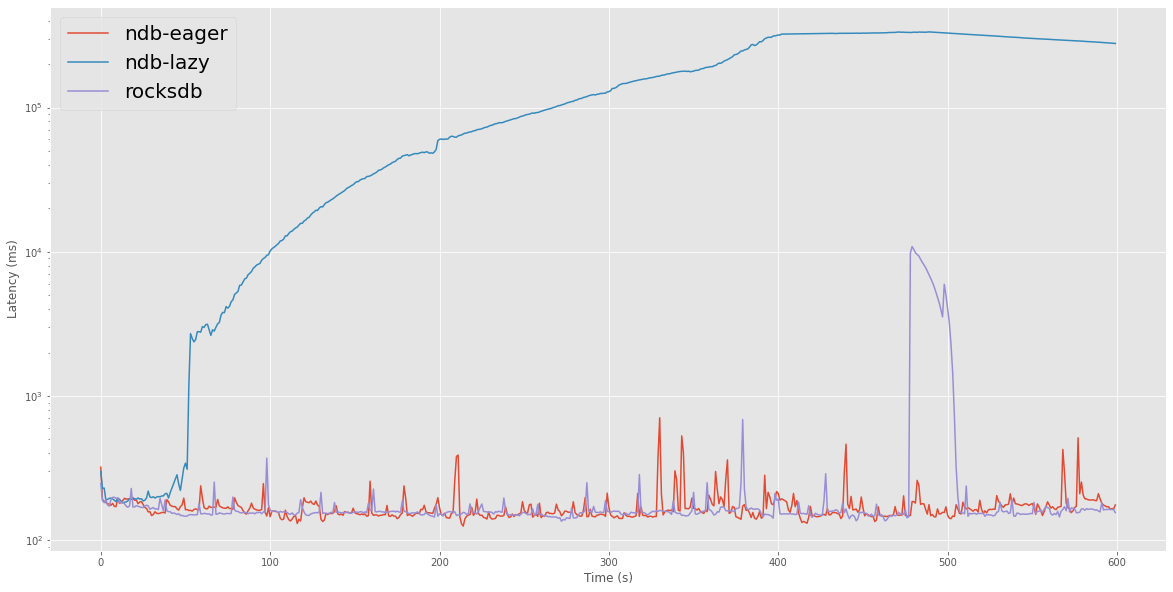

In [14]:
# Latency plot
plt.figure(figsize=(20, 10))
plt.yscale("log")

plt.ylabel("Latency (ms)")
plt.xlabel("Time (s)")

# Set x limits from 0 to max to have plot span to the edges of the figure
ndb_max = ndb_eager_df["startTimeBucket"].max()
rocksdb_max = rocksdb_df["startTimeBucket"].max()
x_max = max(ndb_max, rocksdb_max)
#plt.xlim(0, x_max)
#plt.xlim(430, 490)
#plt.xticks(np.arange(0, x_max, 10.0))


#plt.xlim(450, 510)

# Data plotting
p = ndb_eager_df.groupby("startTimeBucket")["latency"].mean()
plt.plot(p, label="ndb-eager")

p = ndb_lazy_df.groupby("startTimeBucket")["latency"].mean()
plt.plot(p, label="ndb-lazy")

p = rocksdb_df.groupby("startTimeBucket")["latency"].mean()
plt.plot(p, label="rocksdb")

# Add line when failure happens
#plt.axvline(x=444, color="grey", dashes=(10.0, 10.0))

#p = rocksdb_full_df.groupby("startTimeBucket")["latency"].mean()
#plt.plot(p, label="rocksdb-full")

plt.legend(prop={'size': 20})
plt.savefig("/home/christopher/Workspace/statefun-ndb-benchmark/evaluator/figures/latency")

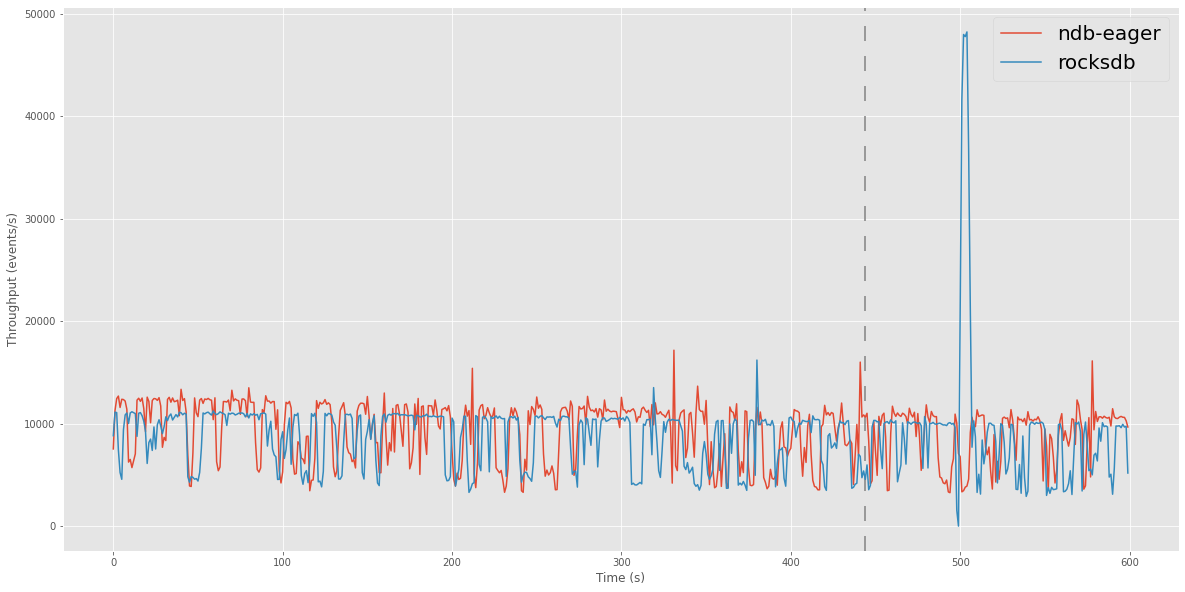

In [13]:
# Throughput plot
plt.figure(figsize=(20, 10))
plt.ylabel("Throughput (events/s)")
plt.xlabel("Time (s)")

# Set x limits from 0 to max to have plot span to the edges of the figure
ndb_max = ndb_eager_df["endTimeBucket"].max()
rocksdb_max = rocksdb_df["endTimeBucket"].max()
x_max = max(ndb_max, rocksdb_max)

#plt.xlim(490, 540)

# Add line when failure happens
plt.axvline(x=444, color="grey", dashes=(10.0, 10.0))


# Data plotting
p = ndb_eager_df.groupby("endTimeBucket")["latency"].count()
p = p.reindex(range(0, x_max), fill_value=0)
plt.plot(p, label="ndb-eager")

p = ndb_lazy_df.groupby("endTimeBucket")["latency"].count()
p = p.reindex(range(0, x_max), fill_value=0)
#plt.plot(p, label="ndb-lazy")

p = rocksdb_df.groupby("endTimeBucket")["latency"].count()
p = p.reindex(range(0, x_max), fill_value=0)
plt.plot(p, label="rocksdb")

#p = rocksdb_full_df.groupby("endTimeBucket")["latency"].count()
#p = p.reindex(range(0, x_max), fill_value=0)
#plt.plot(p, label="rocksdb-full")

plt.legend(prop={'size': 20})

plt.savefig("/home/christopher/Workspace/statefun-ndb-benchmark/evaluator/figures/throughput.png")